In [101]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import datetime

In [80]:
ari_data = pd.read_csv('U://DATA/OpenClassrooms/Data science/P5/data_for_rand_index.csv')
# Convert timestamp column to datetime
ari_data['order_purchase_timestamp'] = pd.to_datetime(ari_data['order_purchase_timestamp'])

In [81]:
ari_data.dtypes

customer_id                         object
customer_unique_id                  object
order_id                            object
order_purchase_timestamp    datetime64[ns]
order_status                        object
product_id                          object
price                              float64
review_score                       float64
dtype: object

In [82]:
def get_data_from_date(
        df : pd.DataFrame,
        date : datetime.date
        ):
    """
    Given a limit date, get all the data from before that date and shape the df to be able to perform clustering with it
    """
    #Cut the data at the date:
    date = pd.Timestamp(date)
    df = df[df['order_purchase_timestamp']<date]

    aggregated_data = df.groupby('customer_unique_id').agg({
    'order_id': 'count',
    'price': 'sum',
    'order_purchase_timestamp': 'max'
    })

    # Find the maximum date from the 'max_purchase_timestamp' column
    max_date = aggregated_data['order_purchase_timestamp'].max()

    # Calculate recency as the number of days between today and the last order
    aggregated_data['recency'] = (max_date - aggregated_data['order_purchase_timestamp']).dt.days

    # Drop the 'max_purchase_timestamp' column
    aggregated_data = aggregated_data.drop('order_purchase_timestamp', axis=1)
    aggregated_data.columns = ['frequency', 'monetary', 'recency']

    return aggregated_data


**How we will proceed:**
- Set a limit date and get all the data from before that date
- Groupby unique_id and perform the same transformation as we did in the clustering notebook
- scale, and train the model on the time limited dataset
- get a new set of data at a later date, in 5 days interval
- use the same scaling and model to predict the cluster on the new set of data
- use the adjusted rand index on both cluster prediciton to see how long it takes for the rand index to drop below 0.8

In [83]:
# Step 1: Split the data at a set date, let's take 90days before the end of our data to keep most of our data in the base training model
# Step 2: transform the data into a useable dataframe for clustering
date = datetime.date(2018,6,1)

main_data = get_data_from_date(ari_data,date)

In [84]:
main_data

,frequency,monetary,recency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,21
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,24
0000f46a3911fa3c0805444483337064,1,69.00,447
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,231
0004aac84e0df4da2b147fca70cf8255,1,180.00,198
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.00,357
fffea47cd6d3cc0a88bd621562a9d061,1,64.89,172
ffff371b4d645b6ecea244b27531430a,1,89.90,478


In [85]:
# Step 3: Scale the data and train the model
scaler = StandardScaler()
scaler.fit(main_data)
main_data_scaled = scaler.transform(main_data)


kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(main_data_scaled)

main_clusters = kmeans.predict(main_data_scaled)
main_data_clusters = main_data.copy()
main_data_clusters['clusters'] = main_clusters
main_data_clusters.head()

,frequency,monetary,recency,clusters
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,21,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,24,1
0000f46a3911fa3c0805444483337064,1,69.00,447,2
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,231,2
0004aac84e0df4da2b147fca70cf8255,1,180.00,198,1


In [98]:
# Step 4 : Get a new set of data at a latter date
new_date = datetime.date(2018,7,10)

new_date_data = get_data_from_date(ari_data,new_date)

#Let's scale and predict the cluster using the already trained models
new_date_scaled = scaler.transform(new_date_data)
new_clusters = kmeans.predict(new_date_scaled)



new_kmeans = KMeans(n_clusters=4, random_state=42)
new_scaler = StandardScaler()

new_date_scaled2 = new_scaler.fit_transform(new_date_data)
new_cluster2 = new_kmeans.fit_predict(new_date_scaled2)

#Let's calculate the adjusted rand index
rand_index = adjusted_rand_score(new_cluster2, new_clusters)
print("Rand Index:", rand_index)

Rand Index: 0.8565018355190741


**To see a bit better the effect of time on the ARI let's plot it**

In [106]:
#let's build a function that plot the ARI by days
def ari_plot(
        df : pd.DataFrame,
        _scaler : StandardScaler,
        _kmeans : KMeans,
        step : int = 5,
        start_date : datetime.date = datetime.date(2018,6,1),
        max_date : datetime.date = datetime.date(2018,9,3)
        ):
    """
        Plots the Adjusted Rand Index (ARI) over time, calculated by comparing the clusters
        formed by a base KMeans model with those formed by a new KMeans model for each step from start_date to max_date.
        
        Parameters
        ----------
        df : pd.DataFrame
            The DataFrame containing the data to be clustered.
        _scaler : StandardScaler
            The scaler used to scale the data.
        _kmeans : KMeans
            The KMeans model used to create the base clusters.
        step : int, optional
            The number of days between each step, by default 5.
        start_date : datetime.date, optional
            The starting date for the steps, by default datetime.date(2018,6,1).
        max_date : datetime.date, optional
            The maximum date for the steps, by default datetime.date(2018,9,3).
    """
     
    # Prepare lists to store dates and ARI values
    dates = []
    ari_values = []

    while start_date < max_date :

        dates.append(start_date)
        new_date_data = get_data_from_date(df,start_date)

        #Let's scale and predict the cluster using the already trained models
        new_date_scaled = _scaler.transform(new_date_data)
        new_clusters = _kmeans.predict(new_date_scaled)

        #Now we need a new scaler and new model
        new_kmeans = KMeans(n_clusters=4, random_state=42)
        new_scaler = StandardScaler()

        new_date_scaled2 = new_scaler.fit_transform(new_date_data)
        #new_date_scaled2 = _scaler.transform(new_date_data) (just in case!)
        new_cluster2 = new_kmeans.fit_predict(new_date_scaled2)
        #Let's calculate the adjusted rand index
        rand_index = adjusted_rand_score(new_cluster2, new_clusters)

        #add the rand index to a list
        ari_values.append(rand_index)

        #add the step in days to the date
        start_date += datetime.timedelta(days=step)

    
     #plot the graph rand index in y, time in x
    plt.figure(figsize=(10, 6))
    plt.plot(dates, ari_values, marker='o')
    plt.axhline(0.8, color='r', linestyle='--')  # Red dashed line at y = 0.8
    plt.xlabel('Date')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Adjusted Rand Index Over Time')
    plt.show()
    
    return

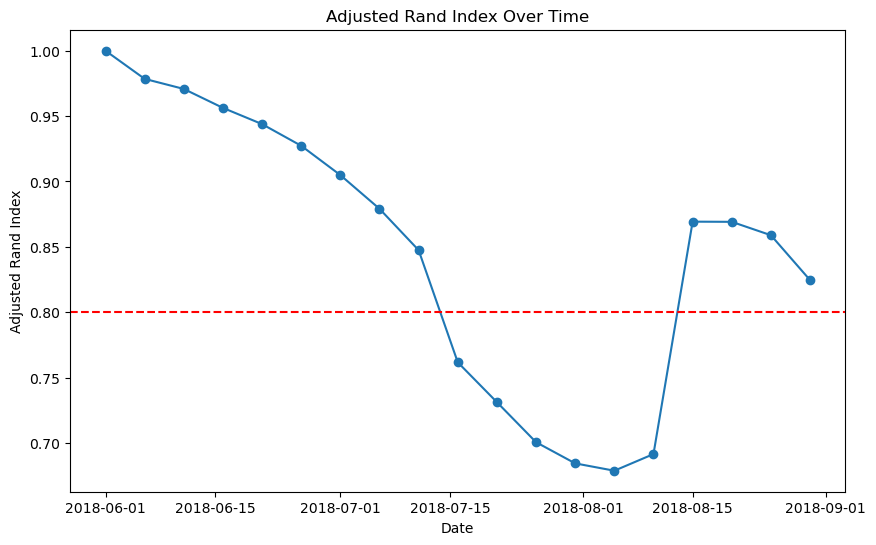

In [105]:
ari_plot(ari_data,scaler,kmeans,5)